In [1]:
#from libs.edgelistParser import edgelistParser
#from libs.utils import list2matrix, getInOutDegree
#from libs.page_rank import approximateSimrank, localPageRank
#from libs.plotNetwork import plotNetworkClusters

# use cython compiled modules for faster execution
from scripts.cython.edgelistParser import edgelistParser
from scripts.cython.utils import list2matrix, getInOutDegree
#from scripts.cython.pageRank import approximateSimrank, localPageRank
from scripts.cython.plotNetwork import plotNetworkClusters

from scripts.cpp_libs.pageRankCpp import cppLocalPageRank

import numpy as np
from matplotlib import pyplot as plt
import heapq as hq
import networkx as nx

In [2]:
# load the Facebook dataset
A, N, D = edgelistParser("datasets/facebook/0.edges", "raw_list")

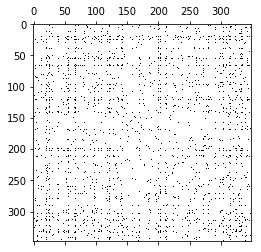

In [3]:
A_mat = list2matrix(A)
plt.figure()
plt.spy(A_mat)
plt.show()

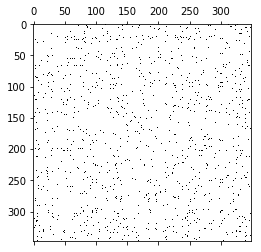

In [4]:
# generate the L matrix
#L = localPageRank(A, c=0.85, return_only_neighbours=True)
L = cppLocalPageRank(A, c=0.85, return_only_neighbours=True)
L_mat = list2matrix(L)
plt.figure()
plt.spy(L_mat)
plt.show()

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


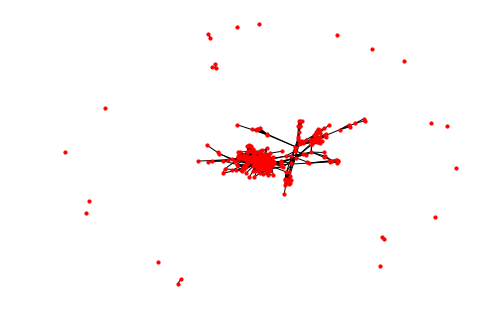

In [5]:
# test the network plot
g = nx.Graph(A_mat)
plt.figure()
nx.draw_spring(g, node_size=10)
plt.show()

In [6]:
# the function computes the network clustering
def cluster(L_norm, centroids, alpha, A, plot_end=True, plot_steps=False):  
    # initialize the output vector with the clusters
    clusters = - np.ones(len(L_norm))
    
    if plot_steps:
        pos = None
        colors = None
    
    # initialize the heap queues related to the clusters
    queues = []
    
    # insert centroids in the queues, e.g. (expansions, (node, rank))
    for i in range(centroids.size):
        queue = []
        hq.heappush(queue, (0, (centroids[i], 1)))
        queues.append(queue)
        
        # set the centroid cluster
        clusters[centroids[i]] = centroids[i]
    
    # iterate until all the nodes are assigned to the clusters   
    exit_ext = False
    while not exit_ext:
        #
        cumulative_length = 0
        for queue in queues:
            # assign the new expansions
            for i, node in enumerate(queue):
                # ensure at least one expansion per node
                expansions = max(1, np.round(alpha*node[1][1])) # TODO: eventually change the round function
                
                # modify the queue element with the new expansions
                queue[i] = (
                    - expansions,
                    (node[1][0], node[1][1])
                )
            
            # restore the queue
            hq.heapify(queue)
            
            #print(queue)
        
            # expand the cluster boundary toward the high ranked nodes
            exit_int = False
            while (not exit_int) and len(queue)>0: # TODO: check correctness
                # pop a node that should be expanded 
                node = hq.heappop(queue)
                #print("popped")
                
                # check the termination condition
                expansions_opp = node[0]
                if expansions_opp==0:
                    # no more nodes to expand
                    exit_int = True
                else:
                    #print("else")
                    # reduce the remained number of expansions
                    expansions_opp += 1
                    
                    # TODO: exploit the edgelist to enhance efficiency and ensure correctness
                    # expand the neighbourhood and assign the new expansions
                    #print("where", np.where(L[node[1][0],:]>0)[0])
                    for edge in L_norm[node[1][0]]:
                        #print(neighbour)
                        neighbour = edge[0]
                        # assign the node to the cluster
                        if clusters[neighbour]<0:
                            #print("assigned")
                            clusters[neighbour] = clusters[node[1][0]]
                            
                            # add the node to the queue
                            rank = edge[1]
                            hq.heappush(
                                queue,
                                (
                                    np.round(expansions_opp*rank), # TODO: eventually change the round function
                                    (neighbour, rank)
                                )
                            )
                            
            # TODO: check
            cumulative_length += len(queue) 
        
        exit_ext = cumulative_length==0
    
        # test plot <-> CLUSTERS SHOULD BE A LIST!
        if plot_steps:
            pos, colors = plotNetworkClusters(A, list(clusters.astype(int)), 5, draw_edges=False, pos=pos, colors=colors)
        
    if plot_end and not plot_steps:
        plotNetworkClusters(A, list(clusters.astype(int)), 5, draw_edges=False)
    
    # return the vector with the clusters
    return clusters

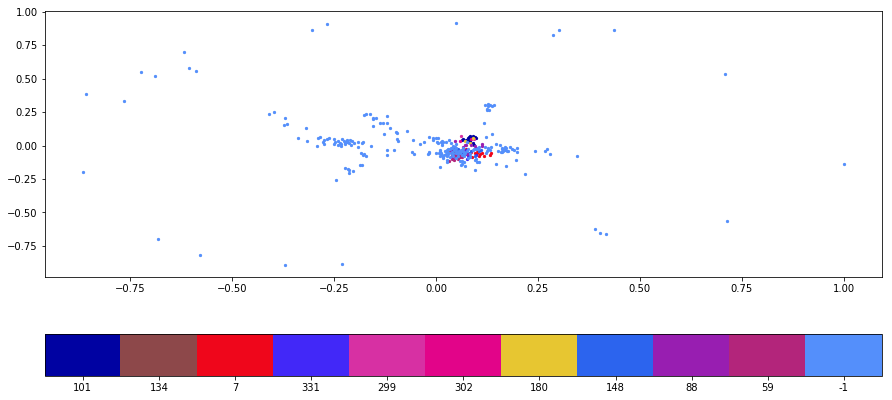

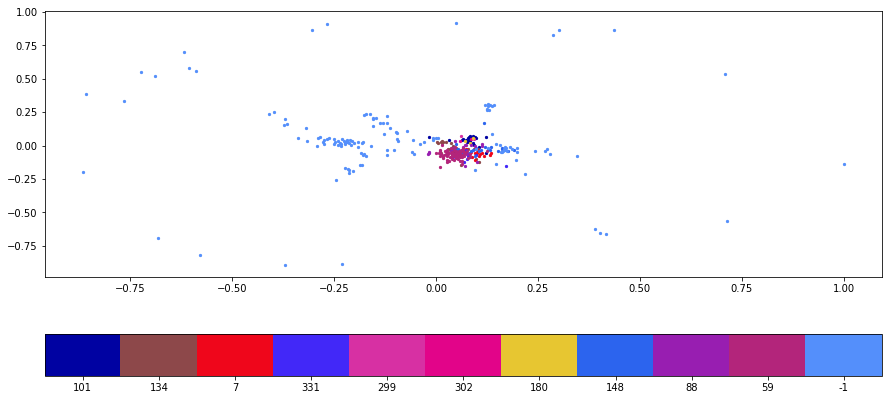

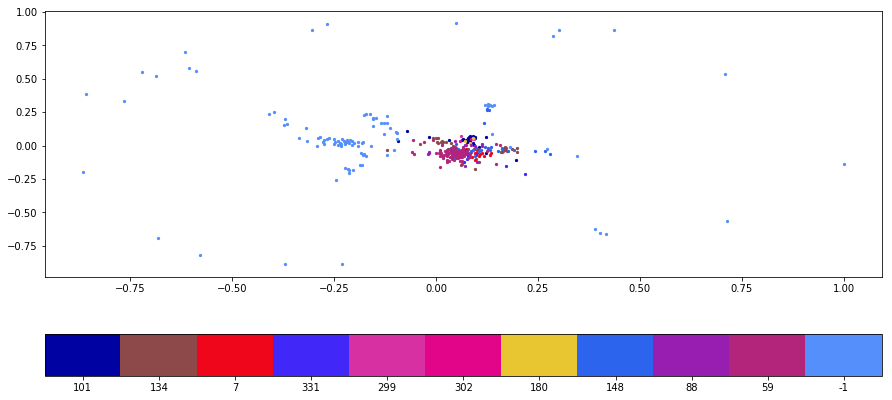

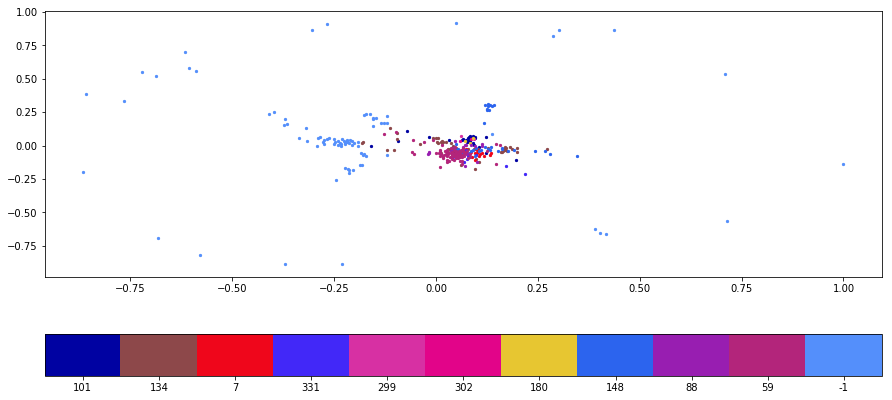

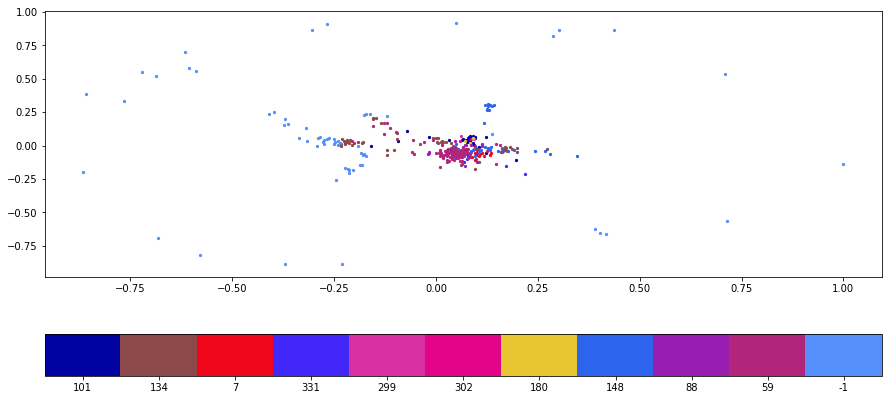

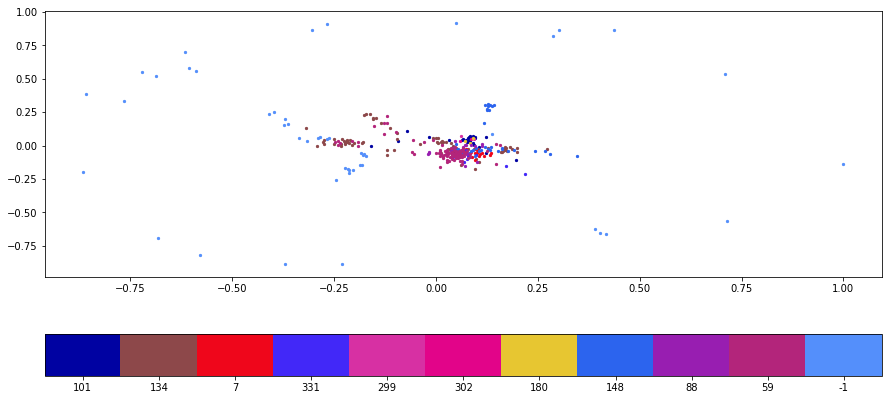

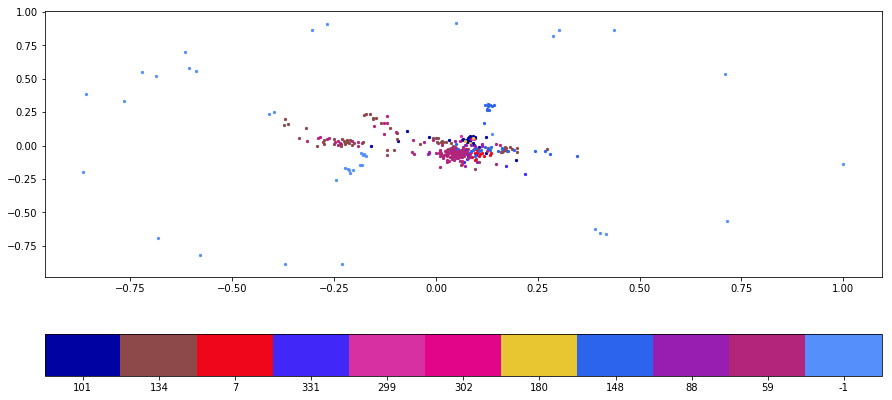

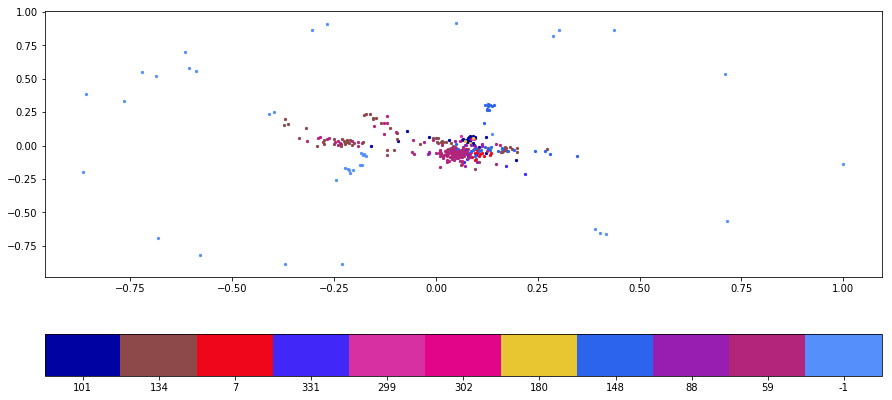

[ -1.  88. 134. 134. 148. 180.  -1.   7. 134. 134. 134.  -1.  -1.  59.
 134.  -1. 331. 134.  -1. 134.  59. 134.   7. 134. 101.  88. 134. 148.
 134.  59. 331.   7.  59.  -1. 101. 134. 134.  -1.   7. 134.  59.  59.
  -1.  -1. 134.  59. 134. 331.  88. 134. 148.  88. 134. 101. 101.  59.
  59. 302. 148.  59.  59. 134.  59.  59. 148.   7. 134. 134. 134. 134.
  59.  59.  59.  88.  -1.  59.  88. 331. 148.  59. 101. 148.  59.  88.
  59.  59. 134.   7.  88.  -1.  -1. 134. 101.  59. 101.  -1. 148.  59.
  59. 134. 148. 101. 134.   7.  59. 148.  88. 148. 134. 148. 134.  59.
  -1. 134.  -1. 134. 134.   7.  59. 148. 134.  59.  59.  59.  59. 148.
  88. 134.  59.   7.  88. 134. 134.  59. 134. 134.   7.  59.  -1.  59.
 134.  59. 134. 134. 134.  -1. 148.  -1. 148. 134. 148. 134. 148.  59.
  -1. 134. 134. 134.  59.  59. 101.  59. 134. 101.  88.  59. 101.  59.
   7.  59.  59. 148.  59. 101.  -1. 134. 148. 134.  88.  -1. 180. 148.
  59.  59. 134. 148.  59. 101.  59. 148. 148. 101. 134. 134. 101. 148.
 180. 

In [7]:
# normalize the rows of L
#L_norm = L/np.sum(L, 1)
#L_norm[np.logical_not(np.isfinite(L_norm))] = 0

# test the clustering algorithm
print(cluster(L, np.array([59, 134, 101, 88, 180, 148, 299, 7, 331, 302]), 5, A_mat, plot_steps=True))
#clusters = cluster(L, np.array(idxs), 5, A_mat)
#_ = plotNetworkClusters(A_mat, clusters, 5, draw_edges=False, pos=None)

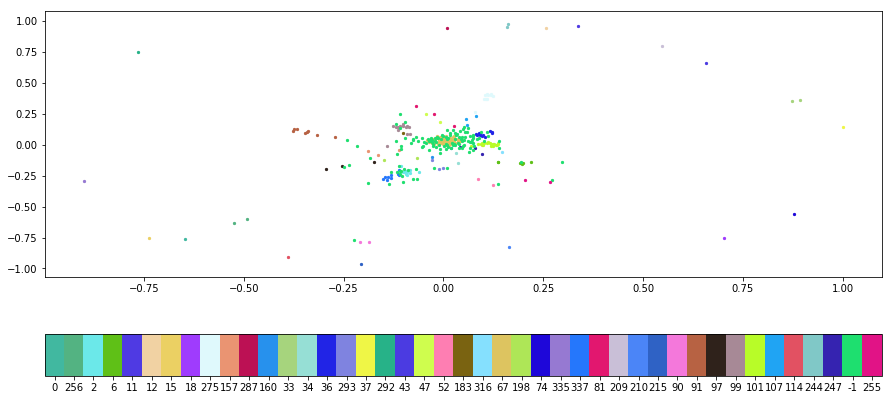

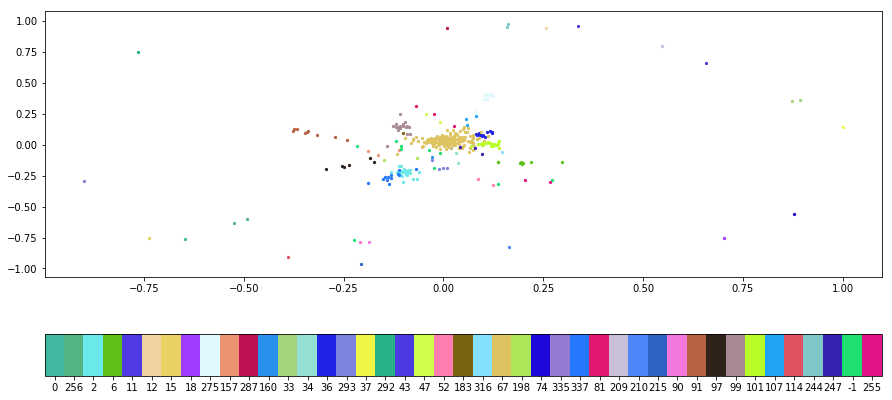

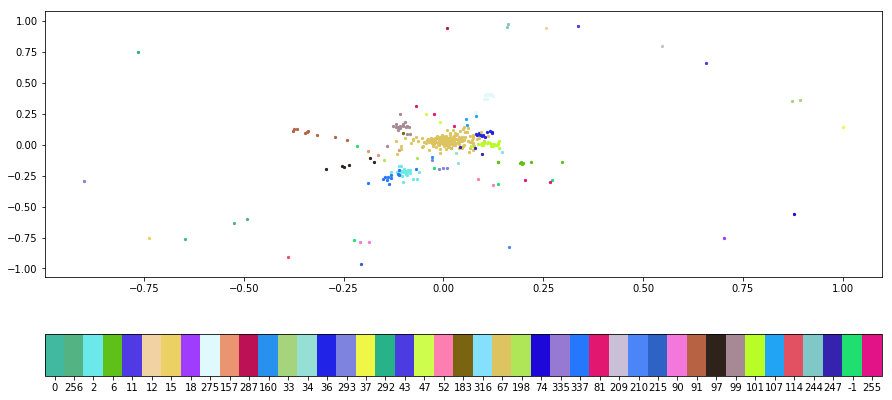

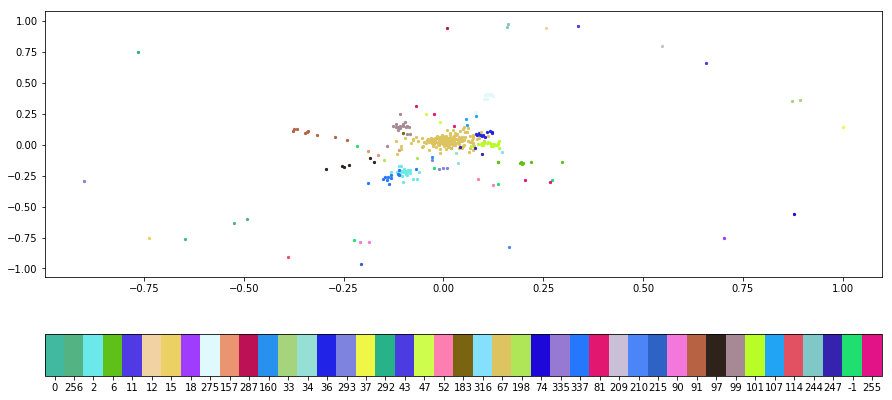

[  0.  67.   2.  67. 275. 316.   6.  67.  91.  67.  67.  11.  12.  67.
   2.  15.  67.   2.  18. 293.   2.  67.  67.  99. 101.  67.  67.  67.
   2. 247.  67.  67. 337.  33.  34.  99.  36.  37.  67.  67.  67. 337.
  33.  43.   2.  67.  99.  47.  67. 255.  67.  67.  52. 101.  67.  67.
  67.  67. 107.  67.  67.  91.  67.  67.  67.  67.  67.  67.  99.  67.
  97.  97.  67.  67.  74.  67.  67.  67. 275.  67. 101.  81.  67.  67.
  67.  67.  99.  67.  67.   6.  90.  91. 101. 337. 101.   6.  67.  97.
  67.  99.  67. 101.  99.  67.  67.  67.  67. 107.  36.  67.  91. 337.
 293.  67. 114.   2.   2.  67.  67.  67. 247.  67.  67.  67. 157.  67.
  67.  36.  67.  67.  67.  99.  67. 183.  67.  36.  67. 337.  -1.  36.
   2.  67.  67.  99.   2.  -1.  67.   6.  67.   2.  67.   2. 275.  67.
   6. 157.  67. 157.  67.  67. 160.  67.   2.  67.  67.  67. 198. 337.
  67.  67.  67. 107.  67.  34. 293.  99.  67.  99.  67.  90. 101. 275.
  97. 183.  36.  67.  67. 101.  67.  67.  67. 101.  52.  91. 101. 275.
  67. 

In [8]:
print(cluster(L, np.array(
     [67, 275, 101, 2, 337, 18, 91, 15, 12, 11, 33, 6, 97, 99, 90, 81, 52, 43, 37, 36, 74, 34, 47, 256, 255, 247, 244, 335, 316, 293, 292, 287, 215, 210, 157, 209, 114, 107, 160, 198, 183, 0]
     ), 5, A_mat, plot_steps=True))

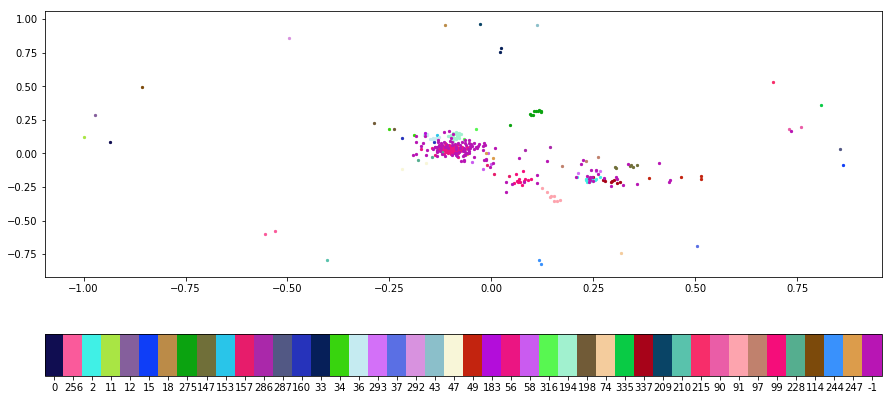

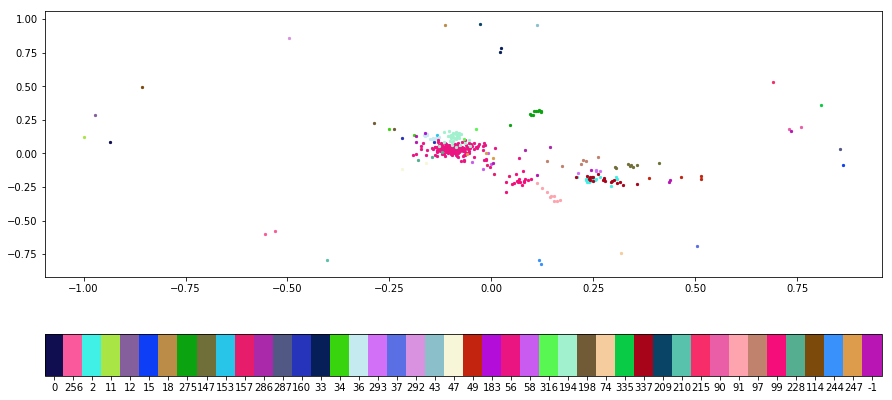

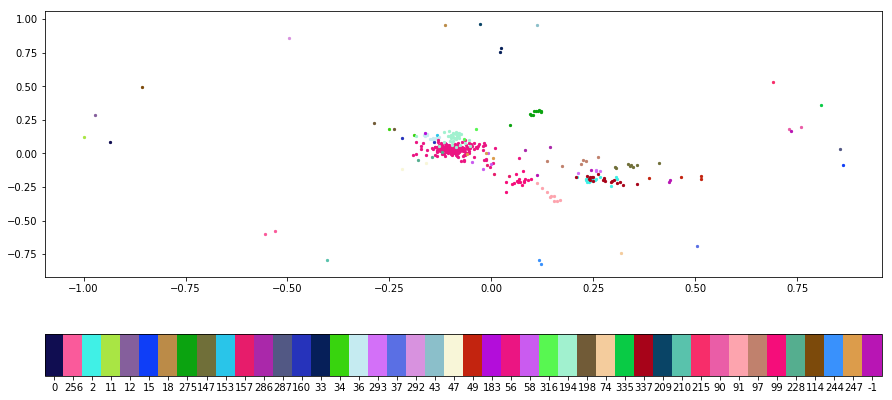

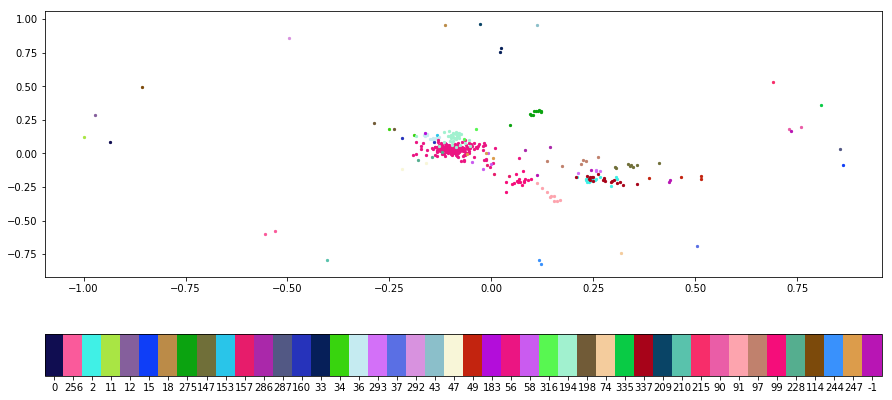

[  0. 194.   2. 228. 275. 316. 147.  56.  91.  56.  56.  11.  12.  56.
 337.  15.  56. 337.  18. 293.   2.  56.  56.  99. 194.  56.  56.  56.
 337. 247.  56.  56. 337.  33.  34.  99.  36.  37.  56.  56.  56. 337.
  33.  43. 337.  56.  99.  47. 194.  49.  56.  56.  -1. 194. 194.  56.
  56. 194.  58.  56.  56.  91.  56.  56.  56.  56.  56.  56.  99.  56.
  97.  97.  56. 194.  74.  56.  56.  56. 275.  56. 194. 286.  56.  56.
  56.  56.  99.  56.  56. 147.  90.  91. 194. 337. 194. 147.  56.  97.
  56.  99.  56. 194.  99.  56.  56.  56.  56.  58.  36.  56.  91. 337.
 293.  56. 114.   2.   2.  56.  56.  56. 247.  56.  56.  56. 157.  56.
  56.  36.  56.  56. 194.  99.  56. 183.  56.  36.  56. 337.  -1.  36.
 337.  56.  56.  99. 337.  -1. 194. 147.  56.   2.  56. 337. 275. 153.
 147. 157.  56. 157. 194.  56. 160.  56.   2. 194.  56.  56. 198. 337.
  56.  56.  56.  58.  56.  34. 293.  99.  56.  99.  56.  90. 194. 275.
  97. 183.  36.  56.  56. 194.  56.  56.  56. 194.  49.  91. 194. 275.
 194. 

In [9]:
print(cluster(L, np.array(
     [194, 147, 56, 275, 337, 2, 33, 90, 11, 91, 47, 34, 97, 58, 99, 15, 49, 74, 12, 43, 18, 37, 36, 256, 247, 244, 228, 335, 316, 293, 292, 287, 286, 215, 210, 157, 153, 114, 160, 209, 198, 183, 0]
     ), 5, A_mat, plot_steps=True))